## Importing Libraries & Building the Dataset Pipeline

In [25]:
import tensorflow as tf 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [57]:
gpus = tf.config.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [110]:
df = pd.read_csv("../dataset/metadata.csv")

In [111]:
test_df = df[df["split"] == "test"]
trainval_df = df[df["split"] == "train"]

###  Splitting the training data into training and validation sets (80/20 split).

In [112]:
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [113]:
train_df.head()

,image_id,split,sat_image_path,mask_path
5070,829196,train,train/829196_sat.jpg,train/829196_mask.png
5895,947864,train,train/947864_sat.jpg,train/947864_mask.png
2344,434989,train,train/434989_sat.jpg,train/434989_mask.png
5014,823500,train,train/823500_sat.jpg,train/823500_mask.png
1921,373567,train,train/373567_sat.jpg,train/373567_mask.png


In [114]:
test_df.head()

,image_id,split,sat_image_path,mask_path
7469,100393,test,test/100393_sat.jpg,NaN
7470,100995,test,test/100995_sat.jpg,NaN
7471,101982,test,test/101982_sat.jpg,NaN
7472,10206,test,test/10206_sat.jpg,NaN
7473,102240,test,test/102240_sat.jpg,NaN


In [115]:
def get_full_path(rel_path):
    return os.path.join("..", "dataset", rel_path)

### Loads and preprocesses an image–mask pair: decoding, resizing, and normalizing for model input.

In [116]:
def load_image_mask(image_path, mask_path, image_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, image_size)
    mask = tf.cast(mask > 127, tf.uint8)

    return image, mask

### Creates a TensorFlow dataset from image–mask paths with batching, shuffling, and prefetching.

In [117]:
def build_dataset(image_paths, mask_paths, batch_size=4, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)

    dataset = dataset.map(lambda x, y: load_image_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [118]:
train_images = train_df["sat_image_path"].apply(get_full_path).tolist()
train_masks = train_df["mask_path"].apply(get_full_path).tolist()

val_images = val_df["sat_image_path"].apply(get_full_path).tolist()
val_masks = val_df["mask_path"].apply(get_full_path).tolist()

In [119]:
train_ds = build_dataset(train_images, train_masks)
val_ds = build_dataset(val_images, val_masks)

## Visualizing Sample Images and Segmentation Masks

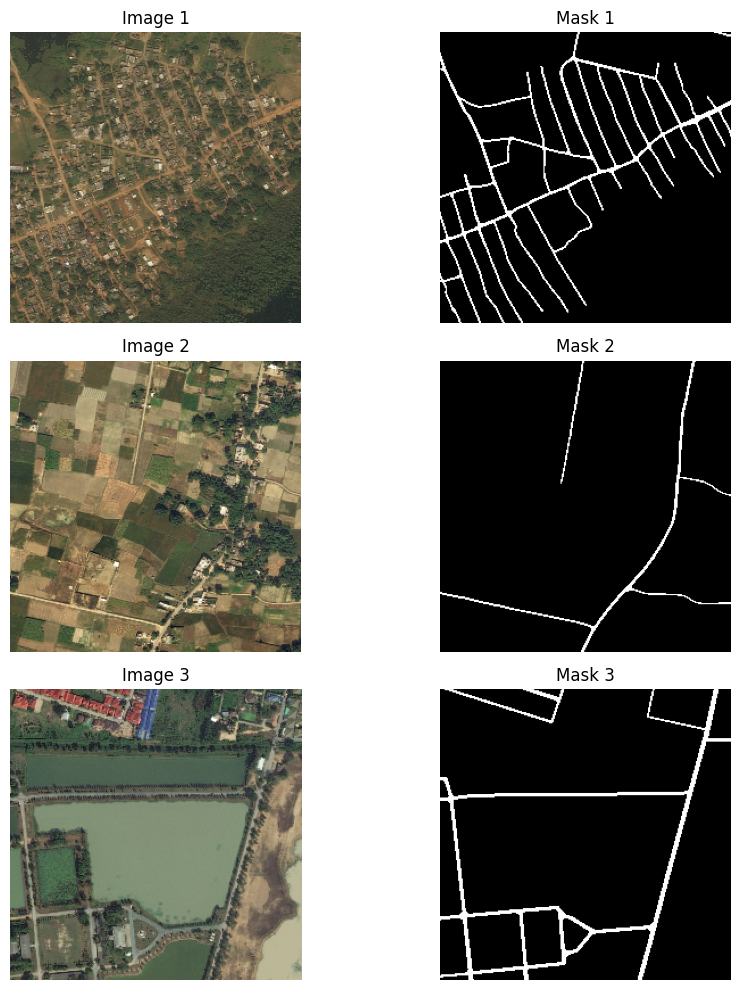

In [120]:
for image_batch, mask_batch in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(3):
        image = image_batch[i].numpy()
        mask = mask_batch[i].numpy().squeeze()

        # Satellite image
        plt.subplot(3, 2, 2*i + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Corresponding mask
        plt.subplot(3, 2, 2*i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

## U-Net Architecture

In [121]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(0.2)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder 
    # s1, p1 = encoder_block(inputs, 64)
    # s2, p2 = encoder_block(p1, 128)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    # b1 = conv_block(p4, 1024)

    # Decoder
    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    # d3 = decoder_block(d2, s2, 128)
    # d4 = decoder_block(d3, s1, 64)

    # Smaller Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b1 = conv_block(p4, 512)

    # Smaller Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    # Output
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return tf.keras.Model(inputs, outputs)

### Custom Loss Function: Binary Crossentropy + Dice Loss

In [122]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

### Custom Metric: Dice Coefficient (F1 Score for Segmentation)

In [123]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    return (2. * intersection + smooth) / (union + smooth)

In [124]:
model = build_unet((256, 256, 3))

model.compile(
    optimizer="adam",
    loss=bce_dice_loss,
    metrics=["accuracy", dice_coef]
)

In [125]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 256, 256,  │      9,248 │ leaky_re_lu_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 128, 128,  │          0 │ re_lu_18[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 128, 128,  │     36,928 │ leaky_re_lu_19[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 64, 64,    │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_99[0][0] 

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## Model Training

In [126]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '../model_weights/scratch_unet_best_model.h5', 
    monitor='val_loss', 
    save_best_only=True  
)

In [127]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 158s 115ms/step - accuracy: 0.9461 - dice_coef: 0.0179 - loss: 1.2192 - val_accuracy: 0.9486 - val_dice_coef: 0.2846 - val_loss: 0.9694
Epoch 2/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9441 - dice_coef: 0.3893 - loss: 0.8631 - val_accuracy: 0.9588 - val_dice_coef: 0.3221 - val_loss: 0.8844
Epoch 3/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9580 - dice_coef: 0.4981 - loss: 0.6942 - val_accuracy: 0.9547 - val_dice_coef: 0.4499 - val_loss: 0.7465
Epoch 4/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9610 - dice_coef: 0.5337 - loss: 0.6396 - val_accuracy: 0.9613 - val_dice_coef: 0.4394 - val_loss: 0.7424
Epoch 5/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9643 - dice_coef: 0.5527 - loss: 0.6053 - val_accuracy: 0.9569 - val_dice_coef: 0.4584 - val_loss: 0.7292
Epoch 6/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.9643 - dice_coef: 0.5747 - loss: 0.580

## Training Progress Visualization

In [128]:
def plot_training_history(history, filename="../Analytics/training_analytics.png"):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    acc_key = 'accuracy' if 'accuracy' in history_dict else 'iou_metric'

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict[acc_key], 'bo-', label=f'Training {acc_key}')
    plt.plot(epochs, history_dict[f'val_{acc_key}'], 'ro-', label=f'Validation {acc_key}')
    plt.title(acc_key.replace('_', ' ').title())
    plt.xlabel('Epochs')
    plt.ylabel(acc_key)
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

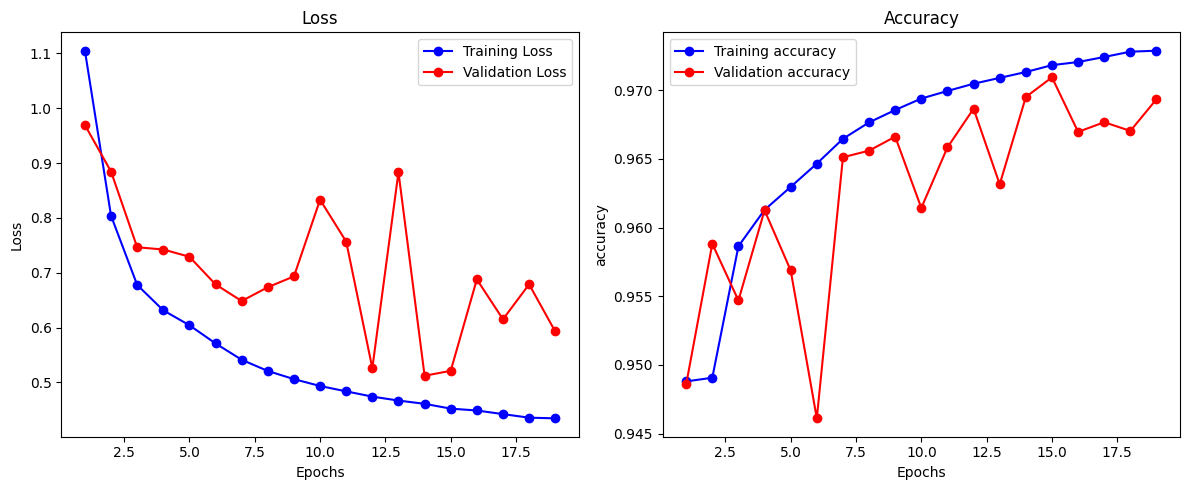

In [129]:
plot_training_history(history)

## Model Predictions Visualization

In [190]:
def display_predictions(model, dataset, num_samples=4):
    plt.figure(figsize=(10, 10))

    for idx, (image_batch, mask_batch) in enumerate(dataset.take(1)):
        preds = model.predict(image_batch)

        for i in range(num_samples):
            image = image_batch[i].numpy()
            mask = mask_batch[i].numpy().squeeze()
            pred_mask = (preds[i] > 0.5).astype("uint8").squeeze()

            plt.subplot(num_samples, 3, i * 3 + 1)
            plt.imshow(image)
            plt.title("Image")
            plt.axis("off")

            plt.subplot(num_samples, 3, i * 3 + 2)
            plt.imshow(mask, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(num_samples, 3, i * 3 + 3)
            plt.imshow(pred_mask, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

        break

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


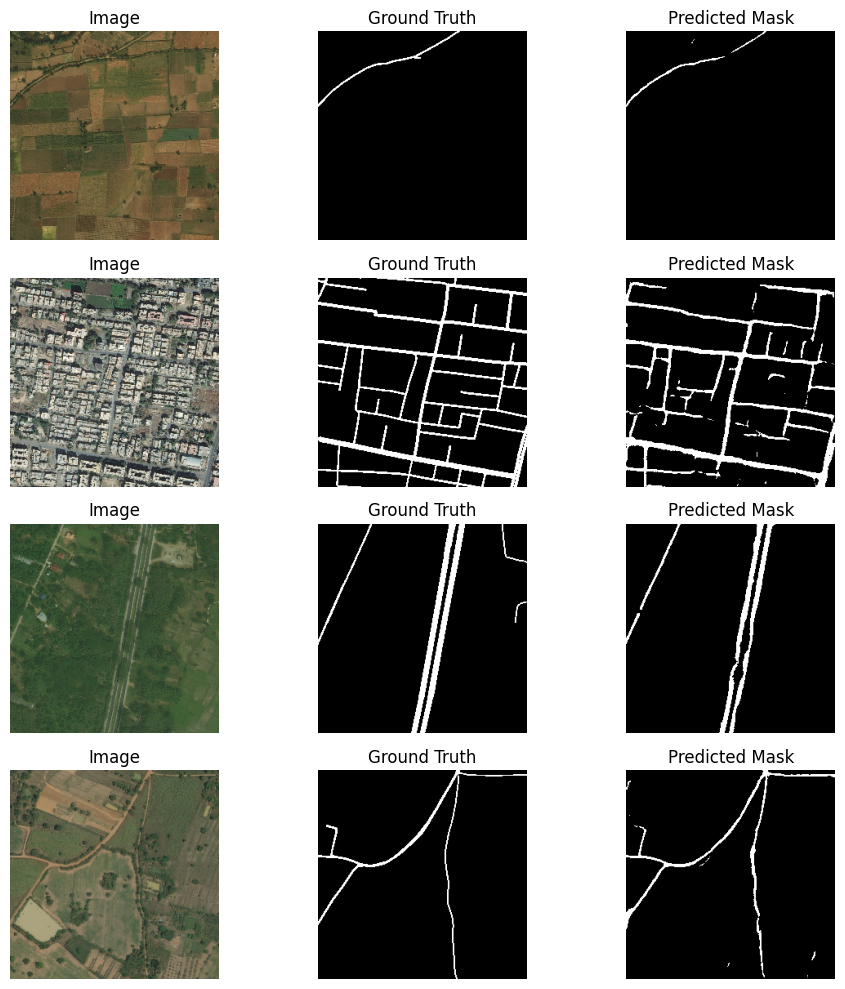

In [191]:
display_predictions(model, val_ds)